# Recurrent Neural Networks

The 4th task is about classification *on tabular data*. What if the approach was wrong? What would happen if we changed the nature of the data?

This notebook revolves around using models for time series to tackle the classification task of the Data Mining project. However, these models shouldn't be compared with those that make use of tabular data, as the validation set will be different, and the data it uses is inherently different. Is still part of task 4 in a sense...

Maybe I'll write a better introduction for this, for now let's move on.

## Autoreload

Autoreload allows the notebook to dynamically load code: if we update some helper functions *outside* of the notebook, we do not need to reload the notebook.

In [1]:
%load_ext autoreload
%autoreload 2

## Imports

As usual, we import all the packages and stuff 

In [2]:
#import procyclingstats as pcs
# Base libraries
import os
import sys
# Basic data manipulation libraries
import numpy as np
import pandas as pd
import itertools
# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm


# Otherwise nothing will be found
sys.path.append(os.path.abspath(os.path.join('..')))

In [3]:
# PyTorch stuff
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

Import from our own utilities

In [4]:
from utility.classification_utility import make_dataset_for_RNN_classification, shift_columns_for_RNN, TO_NOT_USE_COLS, TO_REMOVE_COLS

Other constants, global variables

In [5]:
IMAGES_DIR = os.path.join('Images', 'Clustering_imgs', 'recurrent_models_imgs')

RACES_URL = os.path.join('..', 'dataset', 'races_cleaned.csv')
CYCLISTS_URL = os.path.join('..', 'dataset', 'cyclists_cleaned.csv')

# we define a random state to make the results reproducible
RANDOM_STATE = 42
torch.manual_seed(RANDOM_STATE)
# Whether to run slow stuff
RUN_SLOW_STUFF = False
RUN_PAINFULLY_SLOW_STUFF = False

VAL_PROPORTION = 0.1

Let's set the device for PyTorch (*Andrea: devo usare l'HLT-env purtroppo*)

In [6]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## Dataset Creation

As said, the creation of the dataset is not trivial at all.

In [7]:
merged = make_dataset_for_RNN_classification(cyclists_path=CYCLISTS_URL, races_path=RACES_URL)
merged.shape

(523073, 30)

The cell above takes a long time to run. That's because there's a lot going on

The `make_dataset_for_RNN_classification` removes some more columns:
- `time_seconds`: is just the conversion of the `time` column from string into the n° of seconds (int). With the `timedelta64[s]` datatype, this is not necessary
- `cyclist_age_cyc`: is just `2024 - birth_year` (2024 because it was created last year)

In [8]:
merged.head()

_url_rac  \
cyclist                                                      
aad-van-den-hoek 72148        tour-de-suisse/1975/stage-9b   
                 398199           paris-nice/1976/prologue   
                 408882  omloop-het-nieuwsblad/1977/result   
                 441142  omloop-het-nieuwsblad/1978/result   
                 56937        tour-de-france/1978/prologue   

                                         name_rac     stage stage_type  \
cyclist                                                                  
aad-van-den-hoek 72148             Tour de Suisse  stage-9b        ITT   
                 398199              Paris - Nice  prologue         RR   
                 408882  Omloop Het Nieuwsblad ME       NaN         RR   
                 441142  Omloop Het Nieuwsblad ME       NaN         RR   
                 56937             Tour de France  prologue         RR   

                         points  uci_points    length  climb_total  profile  \
cyclist                                                                       
aad-van-den-hoek 72148      7.0         0.0   20400.0          NaN      NaN   
                 398199     0.0         0.0    6500.0          NaN      NaN   
                 408882     0.0         0.0  201000.0          NaN      NaN   
                 441142     0.0         0.0  218000.0          NaN      NaN   
                 56937      0.0         0.0    5200.0         27.0      1.0   

                         startlist_quality  ... race_country  \
cyclist                                     ...                
aad-van-den-hoek 72148                 549  ...  Switzerland   
                 398199                779  ...       France   
                 408882                595  ...      Belgium   
                 441142                493  ...      Belgium   
                 56937                1241  ...       France   

                         age_performance_index  stamina_index  birth_year  \
cyclist                                                                     
aad-van-den-hoek 72148              -21.241584            NaN      1951.0   
                 398199                    NaN            NaN      1951.0   
                 408882                    NaN            NaN      1951.0   
                 441142                    NaN            NaN      1951.0   
                 56937                     NaN       0.242968      1951.0   

                        weight height  nationality        bmi  \
cyclist                                                         
aad-van-den-hoek 72148    77.0  186.0  Netherlands  22.256908   
                 398199   77.0  186.0  Netherlands  22.256908   
                 408882   77.0  186.0  Netherlands  22.256908   
                 441142   77.0  186.0  Netherlands  22.256908   
                 56937    77.0  186.0  Netherlands  22.256908   

                         partecipants_number  target  
cyclist                                               
aad-van-den-hoek 72148                     6    True  
                 398199                   15    True  
                 408882                   38   False  
                 441142                   31   False  
                 56937                   110   False  

[5 rows x 30 columns]

We notice that the `cyclist` column has now become an index. In fact the `make_dataset_for_RNN_classification`
- **Groups** the rows by cyclist, in order to put together the records of the same cyclist, to create time series of the cyclists
- **Sorts** the rows by date, inside each group
- ~~**Shifts** some columns~~ (not now)

Let's check that all dates are sorted

In [9]:
all_sorted = True
for cyclist in merged.index.levels[0]:
	truth = merged.loc[cyclist, 'date'].is_monotonic_increasing
	if not truth:
		print(f"For {cyclist}, dates are not sorted")
		all_sorted = False

if all_sorted:
	print("All dates are sorted")

All dates are sorted


In [10]:
merged.columns

Index(['_url_rac', 'name_rac', 'stage', 'stage_type', 'points', 'uci_points',
       'length', 'climb_total', 'profile', 'startlist_quality', 'date',
       'position', 'cyclist_age_rac', 'is_tarmac', 'delta', 'time',
       'average_speed', 'steepness', 'season', 'is_staged', 'race_country',
       'age_performance_index', 'stamina_index', 'birth_year', 'weight',
       'height', 'nationality', 'bmi', 'partecipants_number', 'target'],
      dtype='object')

There are a sh*t ton of columns now. And we're not even done yet. I don't like it, but it is what it is.

### Data Selection

Un ripasso, per me ([x] vuol dire che l'ho messa):
- Da **buttare di sicuro**
  - `_url_rac`, 
  - `quality_adjusted_points` se già non viene rimossa. 
  - `age_performance_index`, `age_performance_index_shifted`la RNN sarà più intelligente di una moltiplicazione. E poi sta feature mi ha rotto i cosiddetti
  - `is_tarmac` per piacere	
  - `birth_year`, perché tanto un ciclista che ha NaN come `cyclist_age` ha sicuramente anche NaN come `birth_year`, ma il viceversa è falso. Ovvero, mantenendo `cyclist_age_rac` manteniamo le stesse informazioni di `birth_year` e anche qualcosa in più
- Da **tenere di sicuro**:
  - [x] `length`, `climb_total`, `startlist_quality`, `cyclist_age_rac`, `steepness`, `weigth`, `heigth`, `partecipants_number`
  - [x] `delta_shifted`, `time_shifted`, `position_shifted`, `points_shifted`, `average_speed_shifted`
- Da **buttare forse**:
  - `stamina_index`, `stamina_index_shifted`, `bmi`, in quanto funzioni delle altre features
  - `name_rac`, `stage`
  - `date` Probabilmente è solo un indice. Possiamo estrarre l'anno forse?
- Da **non usare per allenare le RNN**:
  - `delta`, `stamina_index`, `points`, `uci_points`, `average_speed`, `position`, `time`
  - `target` (ovviamente)
- Da **one-hot encodeare forse**:
  - [x] `race_country` (8 valori e nan)
  - [] `name_rac` (27 valori). Se si codifica questa possiamo evitare di codificare quella prima
  - [] `season` (4 valori)
  - [x] `nationality` (73 valori!!!)
  - [x] `stage_type` (2 valori), forse non è una gran feature
- Da **one-hot encodeare di sicuro**:
  - [x] `profile` (5 valori e nan)
  - [x] `is_staged` (2 valori)

Well, something can be done.

In [11]:
merged['is_staged'] = merged['is_staged'].astype(float)
# We encode the NaNs in the profile as -1
merged['profile'] = merged['profile'].astype(float).fillna(-1)
# Rename the stage_type column to is_ITT
merged.rename(columns={'stage_type': 'is_ITT'}, inplace=True)
merged['is_ITT'] = merged['is_ITT'].apply(lambda x: 1. if x == 'ITT' else 0.)

In [12]:
TO_USE_COLS = [
	## race related
	'length', 'climb_total', 'steepness',
	'startlist_quality', 'partecipants_number',
	'cyclist_age_rac',
	'profile', 'is_staged',
	'is_ITT', # not sure about keeping this
	## cyclist related
	'weigth', 'heigth',
	## the shifted features
	'delta_shifted', 'time_shifted',
	'position_shifted', 'average_speed_shifted',
	'points_shifted',
	## maybe encode
	'nationality', 'race_country',
	#'name_rac', We'll use this feature for further manipulations
]

### Isolationg Training set and Development set

Before we do anything else, let's isolate the test set. Altrimenti il Micheli arriva e ci picchia.

In [13]:
merged['date'] >= '2022-01-01'

cyclist                 
aad-van-den-hoek  72148     False
                  398199    False
                  408882    False
                  441142    False
                  56937     False
                            ...  
zoran-klemencic   456303    False
                  206264    False
                  270468    False
                  347100    False
zsolt-der         303113    False
Name: date, Length: 523073, dtype: bool

In [14]:
dev_data = merged[merged['date'] < '2022-01-01']
ts_data = merged[merged['date'] >= '2022-01-01']

# Not very useful in this context
print(f"Dev  set earlier date: {dev_data['date'].min()}, latest date: {dev_data['date'].max()}")
print(f"Test set earlier date: {ts_data['date'].min()}, latest date: {ts_data['date'].max()}")
print()
print(f"Dev  set shape: {dev_data.shape}, i.e. {100*dev_data.shape[0]/merged.shape[0]:>5.2f}% of the data") 
print(f"Test set shape:  {ts_data.shape}, i.e. {100*ts_data.shape[0]/merged.shape[0]:>5.2f}% of the data")
print()
print(f"In terms of actual samples, there are {dev_data.index.get_level_values(0).nunique()} time series in the Dev set, i.e. {100*dev_data.index.get_level_values(0).nunique()/merged.index.get_level_values(0).nunique():>5.2f}% of the total")
print(f"In terms of actual samples, there are {ts_data.index.get_level_values(0).nunique()} time series in the Test set, i.e. {100*ts_data.index.get_level_values(0).nunique()/merged.index.get_level_values(0).nunique():>5.2f}% of the total")
print("(Keep in mind that the data doesn't overlap, but the cyclists do)")

Dev  set earlier date: 1970-02-28 00:00:00, latest date: 2021-10-09 00:00:00
Test set earlier date: 2022-02-21 00:00:00, latest date: 2023-07-29 00:00:00

Dev  set shape: (492644, 30), i.e. 94.18% of the data
Test set shape:  (30429, 30), i.e.  5.82% of the data

In terms of actual samples, there are 5764 time series in the Dev set, i.e. 94.91% of the total
In terms of actual samples, there are 1006 time series in the Test set, i.e. 16.57% of the total
(Keep in mind that the data doesn't overlap, but the cyclists do)


In this split is almost certain that some cyclists appear both in the training and in the test set, but with different data. Again, it is what it is. What's important is to respect the golden rule, otherwise Micheli arrives and steals all of our Buccellato

### Columns shifting

Now that we've isolated training, and test set we can **shift** columns

In [15]:
prev_columns = dev_data.columns
dev_data = shift_columns_for_RNN(dev_data)
new_columns = dev_data.columns
print(f"Columns added: {set(new_columns) - set(prev_columns)}")

Columns added: {'delta_shifted', 'age_performance_index_shifted', 'target_shifted', 'time_shifted', 'stamina_index_shifted', 'average_speed_shifted', 'position_shifted', 'points_shifted'}


A few more words on the columns shifting.

For the tabular data models we can't use some of the columns' values, we can just use the past values to compute the current prediction. For example, we can't use the current value for the `position` feature to predict if the cyclist is in the top 20, but we can use all the past values as we see fit.

In the exploration, we identified features such as `average_position` that make use of these "forbidden values", as they make use of all the data available. Thus, they have to be computed for each timestep. For example, each record of a cyclist has the `average_position` value it had at the point of his career that corresponds to this record, excluding the current `position` value.

In this way, classifiers based on tabular data can make use of these weird features.

Well, for sequence models we don't need these summarizations. We leave it to the model to use all the values of the sequence seen so far, for its training, sa it sees fit. The only thing we have to make sure is to not use the current one. Hence the column shifting.

Let's check that the shift is successful

In [16]:
def inefficient_comparer(l1:pd.Series, l2:pd.Series) -> bool:
	"""Compares two series (inefficiently).
	Unfortunately this is needed to take into account the NaNs
	as `np.nan == np.nan` is False"""
	for i, j in zip(l1, l2):
		if (pd.isna(i) and pd.isna(j)) or i == j:
			continue
		else:
			return False
	return True

#Wrong!
def inefficient_comparer_mk2(l1: pd.Series, l2: pd.Series) -> bool:
    """Compares two series efficiently, taking NaNs into account."""
    return l1.astype(str).equals(l2.astype(str)) or (pd.isna(l1) & pd.isna(l2)).all()

# I swear it wasn't this slow I don't know what happened
# Trust me don't run this
if RUN_SLOW_STUFF and RUN_PAINFULLY_SLOW_STUFF:
	all_shifted_correctly = True
	for cyclist in tqdm.tqdm(dev_data.index.get_level_values(0)):
		for col in set(TO_NOT_USE_COLS) - {'time_seconds'}:
			l1 = dev_data.loc[cyclist, col][:-1].reset_index(drop=True)
			l2 = dev_data.loc[cyclist, f"{col}_shifted"][1:].reset_index(drop=True)
			truth = inefficient_comparer(l1, l2)
			if not truth:
				print(f"For {cyclist}, {col} and {col}_shifted are not shifted correctly")
				all_shifted_correctly = False

	if all_shifted_correctly:
		print("All columns are shifted correctly")

### Isolating the Validation set

We need a validation set to tune our precious hyperparameters. Since our data is time series data, it is only natural that we choose some cyclists as validation data.

I'm lazy and poor, I have an Nvidia GPU but don't tell anyone. On the other hand, data is plentiful. Therefore I just hold out some of the data for validation. No K-folds, no fancy stuff. Via su che sono quelle facce. Dai, non fatemi sentire in colpa.

We randomly select a portion of the development set data, uniformly over the `birth_years` of the cyclists. We do this because we want to be "translation invariant". I mean, we want our recurrent models to capture a behaviour that generalizes over time. The assumption being that cyclism is cyclism, regardless of the year.

In [17]:
# We create a simple df with all the cyclists and their birth year in an overcomplicated way
dev_cyc_and_date = dev_data.groupby('cyclist')['birth_year'].first()
dev_cyc_and_date = dev_cyc_and_date.to_frame().reset_index()
# We bin the birth years, to sample inside the bins 
# (sampling over the birth years individually woudln't work, as there are only a few cyclists born in the same year)
dev_cyc_and_date['birth_year_bin'] = pd.cut(dev_cyc_and_date['birth_year'], bins=range(int(dev_cyc_and_date['birth_year'].min()), int(dev_cyc_and_date['birth_year'].max() + 5), 5), right=False)
dev_cyc_and_date.groupby('birth_year_bin', observed=True)['cyclist'].agg(['unique','count'])

,unique,count
birth_year_bin,,
"[1933, 1938)","[aldo-moser, hans-junkermann, jaak-de-boever, ...",8
"[1938, 1943)","[adriano-passuello, albert-hitchen, albert-van...",74
"[1943, 1948)","[adriano-pella, agustin-tamames, aime-delaere,...",232
"[1948, 1953)","[aad-van-den-hoek, abelardo-rios, adri-jos-sch...",287
"[1953, 1958)","[ad-prinsen, ad-van-peer, adelino-teixeira, ad...",383
"[1958, 1963)","[acacio-da-silva, ad-wijnands, adriano-baffi, ...",574
"[1963, 1968)","[abelardo-rondon, adrian-timmis, adrie-kools, ...",601
"[1968, 1973)","[aart-vierhouten, abraham-olano-manzano, agust...",608
"[1973, 1978)","[addy-engels, adrian-palomares, aitor-gonzalez...",637


We finally sample *the cyclists* (we can index on the cyclists in fact)

In [18]:
# Sometimes I'm stunned of how convoluted Pandas can be
sampled_val_cyclists = dev_cyc_and_date.groupby('birth_year_bin', observed=True)['cyclist'].apply(lambda x: x.sample(frac=VAL_PROPORTION, random_state=RANDOM_STATE)).values

Let's visually compare the n° of sampled cyclists over their birth years

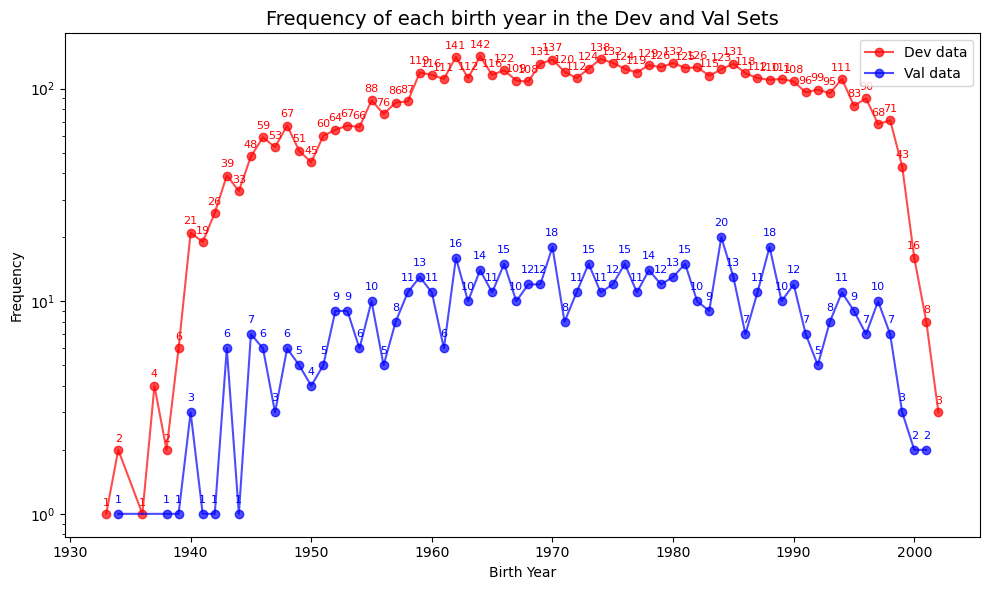

In [19]:
plt.figure(figsize=(10, 6))

dev_counts = dev_cyc_and_date['birth_year'].value_counts().sort_index()
# Rendiamoci conto...
val_counts = dev_data.loc[sampled_val_cyclists].groupby('cyclist')['birth_year'].apply(lambda x: np.unique(x)[0]).value_counts().sort_index()

plt.plot(dev_counts, marker='o', color='red', alpha=0.7, label='Dev data')
plt.plot(val_counts, marker='o', color='blue', alpha=0.7, label='Val data')

for x, y in dev_counts.items():
	plt.annotate(f'{y}', (x, y), textcoords="offset points", xytext=(0,6), ha='center', fontsize=8, color='red')

for x, y in val_counts.items():
	plt.annotate(f'{y}', (x, y), textcoords="offset points", xytext=(0,8), ha='center', fontsize=8, color='blue')

plt.xlabel('Birth Year')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Frequency of each birth year in the Dev and Val Sets', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

Looks really good. Very homogeneous. The blue curve is kind of a scaled version of the red one, which is what we wanted.

Now let's create the training and validation data

In [20]:
val_data = dev_data.loc[sampled_val_cyclists]
tr_data = dev_data.drop(val_data.index)

Did everything go well?

In [21]:
set(tr_data.index.get_level_values(0).unique()) | set(val_data.index.get_level_values(0).unique()) == set(dev_data.index.get_level_values(0).unique())

True

In [22]:
print(f"Training set shape: {tr_data.shape}, i.e. {100*tr_data.shape[0]/dev_data.shape[0]:>5.2f}% of the data")
print(f"Validation set shape: {val_data.shape}, i.e. {100*val_data.shape[0]/dev_data.shape[0]:>5.2f}% of the data")
print()
print(f"In terms of actual samples, there are {tr_data.index.get_level_values(0).nunique()} time series in the Training set, i.e. {100*tr_data.index.get_level_values(0).nunique()/dev_data.index.get_level_values(0).nunique():>5.2f}% of the total")
print(f"In terms of actual samples, there are {val_data.index.get_level_values(0).nunique()} time series in the Validation set, i.e. {100*val_data.index.get_level_values(0).nunique()/dev_data.index.get_level_values(0).nunique():>5.2f}% of the total")

Training set shape: (444492, 38), i.e. 90.23% of the data
Validation set shape: (48152, 38), i.e.  9.77% of the data

In terms of actual samples, there are 5189 time series in the Training set, i.e. 90.02% of the total
In terms of actual samples, there are 575 time series in the Validation set, i.e.  9.98% of the total


Precisely what we wanted.

### Encoding of some columns

For now let's jump straight to the training, eventually we'll think about this later.

**IDEA**:
- 1 hot encode the following nationalities for the cyclists: italian, french, belgian, dutch, spanish, swiss, other
- 1 hot encode the nations in which the races are held: Italy, France, Belgium, Netherlands, Spain, Switzerland, *other* the problem is that "other" is only in the test set!! How do we do? (I guess there are a bunch of zeros in the one hot encoding...)

### PyTorch datasets

I wasted too much time creating the datasets, when the truth is that PyTorch maybe could have offered a way to do this more easily. But Who knows?

In [57]:
class CyclistDataset(Dataset):
	"""Class for the Cyclist Dataset.

	Args:
		Dataset (_type_): _description_
	"""
	def __init__(self, 
			  	df:pd.DataFrame, 
				race_related_features:list[str] = ['length', 'climb_total', 'steepness', 
											'startlist_quality', 'partecipants_number',
											'cyclist_age_rac', 'profile', 'is_staged', 'is_ITT',
											# The next ones I don't wish to use for now
											'race_country', 'season'
											],
				cyclist_related_features:list[str] = ['weigth', 'heigth', 
										  				# The next ones I don't wish to use for now 
										  				'nationality'],
				shifted_features:list[str] = ['delta_shifted', 'time_shifted', 'position_shifted', 'average_speed_shifted', 'points_shifted'],
				# Probably I will never do anything with this
				forbidden_features:list[str] = TO_NOT_USE_COLS,
				to_encode_features:list[str] = ['race_country', 'season', 'nationality'],
				transforms=None # The data transformations. I'll have to think about this
		):
		# Maybe I'll need to name mangle
		self.df = df
		self.grouped = df.groupby(level=0)
		self.columns = df.columns
		self.cyclists = df.index.get_level_values(0).unique()
		self.cyclist_related_features = [col for col in cyclist_related_features if col in self.columns]
		self.race_related_features = [col for col in race_related_features if col in self.columns]
		# to be soon deleted
		self.shifted_features = [col for col in shifted_features if col in self.columns]
		self.forbidden_features = [col for col in forbidden_features if col in self.columns]

	def __len__(self) -> int:
		# Return the n° of time series (hence cyclists)
		return len(self.cyclists)
	
	def __shift_columns(self, data) -> pd.DataFrame:
		"""Shifts the columns that need to be shifted"""
		# I hate to do all this stupid copying, 
		# hopefully Python has a good garbage collector
		shifted = data.copy()
		for col in self.forbidden_features:
			shifted.loc[:, f"{col}_shifted"] = shifted[col].shift(1)
		return shifted

	def __getitem__(self, idx:int):
		# Get the cyclist
		cyclist = self.cyclists[idx]
		# Get the data for the cyclist
		data = self.grouped.get_group(cyclist)
		# create the shifted columns
		data = self.__shift_columns(data) # it's a copy!
		# Get the labels (sequence)
		labels = data['target'].values
		# Drop the columns that we can't use
		ret_data = data.drop(columns=self.forbidden_features)

		return ret_data, labels
	
	def __iter__(self): 
		for i in range(len(self)):
			yield self.__getitem__(i)

---

In [54]:
merged.columns

Index(['_url_rac', 'name_rac', 'stage', 'is_ITT', 'points', 'uci_points',
       'length', 'climb_total', 'profile', 'startlist_quality', 'date',
       'position', 'cyclist_age_rac', 'is_tarmac', 'delta', 'time',
       'average_speed', 'steepness', 'season', 'is_staged', 'race_country',
       'age_performance_index', 'stamina_index', 'birth_year', 'weight',
       'height', 'nationality', 'bmi', 'partecipants_number', 'target'],
      dtype='object')

In [58]:
prova_dataset_merged = CyclistDataset(merged)

In [63]:
cyclist = prova_dataset_merged.cyclists[0]
ritorno = prova_dataset_merged._shift_columns(prova_dataset_merged.grouped.get_group(cyclist))

In [66]:
prova_dataset_merged.columns

Index(['_url_rac', 'name_rac', 'stage', 'is_ITT', 'points', 'uci_points',
       'length', 'climb_total', 'profile', 'startlist_quality', 'date',
       'position', 'cyclist_age_rac', 'is_tarmac', 'delta', 'time',
       'average_speed', 'steepness', 'season', 'is_staged', 'race_country',
       'age_performance_index', 'stamina_index', 'birth_year', 'weight',
       'height', 'nationality', 'bmi', 'partecipants_number', 'target'],
      dtype='object')

In [68]:
all(ritorno['position_shifted'][1:].reset_index(drop=True) == ritorno['position'][:-1].reset_index(drop=True))

True

---

## RNNs training

Ci siamo... Non si scappa...

In [31]:
grouped = tr_data.groupby(level=0)
cyclists = tr_data.index.get_level_values(0).unique()

In [34]:
data = grouped.get_group(cyclists[1])
data

_url_rac  \
cyclist                                               
aaron-gate 276137  liege-bastogne-liege/2017/result   
           484815       tour-de-suisse/2017/stage-1   
           449172       tour-de-suisse/2017/stage-2   
           390293       tour-de-suisse/2017/stage-3   
           512769       tour-de-suisse/2017/stage-4   
           401058       tour-de-suisse/2017/stage-5   
           441566       tour-de-suisse/2017/stage-6   
           437546       tour-de-suisse/2017/stage-7   
           308050       tour-de-suisse/2017/stage-8   
           71696        tour-de-suisse/2017/stage-9   
           393497      vuelta-a-espana/2017/stage-2   
           322937      vuelta-a-espana/2017/stage-3   
           512289      vuelta-a-espana/2017/stage-4   
           435486      vuelta-a-espana/2017/stage-5   
           28908       vuelta-a-espana/2017/stage-6   
           316665      vuelta-a-espana/2017/stage-7   
           148463      vuelta-a-espana/2017/stage-8   
           84890       vuelta-a-espana/2017/stage-9   
           95922      vuelta-a-espana/2017/stage-10   
           342638     vuelta-a-espana/2017/stage-11   
           65807      vuelta-a-espana/2017/stage-12   
           520643     vuelta-a-espana/2017/stage-13   
           494943     vuelta-a-espana/2017/stage-14   
           45149      vuelta-a-espana/2017/stage-15   
           40608      vuelta-a-espana/2017/stage-16   
           490905     vuelta-a-espana/2017/stage-17   
           109039     vuelta-a-espana/2017/stage-18   
           689        vuelta-a-espana/2017/stage-20   
           53116      vuelta-a-espana/2017/stage-21   
           82900   liege-bastogne-liege/2018/result   

                                      name_rac     stage  is_ITT  points  \
cyclist                                                                    
aaron-gate 276137     Liège - Bastogne - Liège       NaN     0.0     5.0   
           484815               Tour de Suisse   stage-1     1.0     0.0   
           449172               Tour de Suisse   stage-2     0.0     0.0   
           390293               Tour de Suisse   stage-3     0.0     0.0   
           512769               Tour de Suisse   stage-4     0.0     0.0   
           401058               Tour de Suisse   stage-5     0.0     2.0   
           441566               Tour de Suisse   stage-6     0.0     0.0   
           437546               Tour de Suisse   stage-7     0.0     0.0   
           308050               Tour de Suisse   stage-8     0.0     0.0   
           71696                Tour de Suisse   stage-9     1.0     0.0   
           393497  La Vuelta ciclista a España   stage-2     0.0     0.0   
           322937  La Vuelta ciclista a España   stage-3     0.0     0.0   
           512289  La Vuelta ciclista a España   stage-4     0.0     0.0   
           435486  La Vuelta ciclista a España   stage-5     0.0     0.0   
           28908   La Vuelta ciclista a España   stage-6     0.0     0.0   
           316665  La Vuelta ciclista a España   stage-7     0.0     0.0   
           148463  La Vuelta ciclista a España   stage-8     0.0     0.0   
           84890   La Vuelta ciclista a España   stage-9     0.0     0.0   
           95922   La Vuelta ciclista a España  stage-10     0.0     0.0   
           342638  La Vuelta ciclista a España  stage-11     0.0     0.0   
           65807   La Vuelta ciclista a España  stage-12     0.0     0.0   
           520643  La Vuelta ciclista a España  stage-13     0.0     0.0   
           494943  La Vuelta ciclista a España  stage-14     0.0     0.0   
           45149   La Vuelta ciclista a España  stage-15     0.0     0.0   
           40608   La Vuelta ciclista a España  stage-16     1.0     0.0   
           490905  La Vuelta ciclista a España  stage-17     0.0     0.0   
           109039  La Vuelta ciclista a España  stage-18     0.0     0.0   
           689     La Vuelta ciclista a España  stage-20     0.0     0.0   
  

In [36]:
data['target'].values

array([False, False,  True, False, False,  True, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])